**Sumber Dataset**
- [Dataset](https://www.kaggle.com/competitions/rsna-pneumonia-detection-challenge/data)
- [Label](https://raw.githubusercontent.com/fshnkarimi/Cardiac-Detection/main/rsna_heart_detection.csv)

### Import Library
`pydicom` untuk membaca file DICOM (Install menggunakan `pip install pydicom`)

In [1]:
# Basic Packages
import pydicom
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D

# SkLearn
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import box_iou

# Albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# PyTorch Lightning
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor

/home/bestlabmct/miniconda3/envs/py38_tutorial/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Dataset

In [ ]:
label_df = pd.read_csv('../data/rsna_heart_detection.csv')
label_df.tail()

In [ ]:
TRAIN_DATASET = Path('../data/stage_2_train_images')
TEST_DATASET = Path('../data/stage_2_test_images')
SAVE_PATH = Path('../data/processed_images')

#### Fungsi untuk membaca file DICOM

In [ ]:
def dicomreadimage(name, path=TRAIN_DATASET):
    """Read dicom image and return numpy array"""
    dcmpath = path / f'{name}.dcm'
    dcmdata = pydicom.dcmread(dcmpath)
    image = dcmdata.pixel_array
    return image

#### Preview Data dan Bounding Box

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(5, 5))
for i in range(2):
    for j in range(2):
        data = label_df.sample()
        name = data['name'].values[0]
        img = dicomreadimage(name)
        img = cv2.resize(img, (224, 224))
        print(img.shape)

        #bounding box
        x = data['x0'].values[0]
        y = data['y0'].values[0]
        w = data['w'].values[0]
        h = data['h'].values[0]
        print(x, y, w, h)
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        ax[i, j].imshow(img, cmap='bone')
        ax[i, j].add_patch(rect)
        ax[i, j].axis('off')

In [ ]:
for counter, name in enumerate(list(label_df.name)):
    img = dicomreadimage(name)
    img = cv2.resize(img, (224, 224))
    img = (img / 255).astype(np.float16)

    save_path = SAVE_PATH
    save_path.mkdir(parents=True, exist_ok=True)
    np.save(save_path / name, img)
    

## Training dan Validasi

In [2]:
RANDOM_STATE = 45
LABEL_CSV = Path('../data/rsna_heart_detection.csv')
IMAGE_CSV = Path('../data/processed_images')
data_df = pd.read_csv(LABEL_CSV)
data_df.head()

,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,91,71,77,102,ca112a3c-b701-48b8-a94f-725ea65416a7,224,224
1,heart,70,64,89,67,e5f292ae-f1e5-497c-b0a0-68f1aa2196b2,224,224
2,heart,82,55,81,76,67af68f7-7ba0-49a0-a373-3a8801eb0faa,224,224
3,heart,93,74,78,89,814289a3-9ce8-4cba-842f-45d6a36f540d,224,224
4,heart,85,61,85,93,e508969f-c931-462b-aa90-ccde34a4d9e5,224,224


#### Split Dataset

In [3]:
train_df, val_df = train_test_split(data_df, test_size=0.1, random_state=RANDOM_STATE)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Panjang data train: {len(train_df)} | Panjang data validasi: {len(val_df)}")
train_df.head()

Panjang data train: 446 | Panjang data validasi: 50


,label,x0,y0,w,h,name,img_shape_x,img_shape_y
0,heart,80,65,80,89,d7ff9878-2324-4ca8-a09d-81d98648a562,224,224
1,heart,76,80,84,142,6bbf5c58-7820-4031-97cd-6fbf41ab8f29,224,224
2,heart,68,69,95,111,83424b71-1be1-4c9b-9f3c-9e26e4d3803f,224,224
3,heart,105,82,62,90,6174e549-615d-45da-9b32-150b0a5a6bf3,224,224
4,heart,93,86,64,80,cc12cc3f-4aed-4814-a7a1-64651bbeeaa5,224,224


In [4]:
img_name = train_df.iloc[0,5] + ".npy"
img_path = IMAGE_CSV / img_name
img = np.load(img_path)
print(img.shape)

(224, 224)


#### Kelas Data Reader

In [5]:
class CardiacDatareader(Dataset):
    def __init__(self, df, aug=None):
        self.df = df
        self.aug = aug

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 5]
        img_data = np.load(IMAGE_CSV / f"{img_id}.npy").astype(np.float32)

        #load bounding box
        x = self.df.iloc[idx, 1]
        y = self.df.iloc[idx, 2]
        w = self.df.iloc[idx, 3]
        h = self.df.iloc[idx, 4]

        xmax = x + w
        ymax = y + h

        bbox = [x, y, xmax, ymax]
        label = ["heart"]

        if self.aug:
            bbox = bbox + label
            transformed = self.aug(image = img_data, bboxes = [bbox])
            img_data = transformed['image']
            bbox = transformed['bboxes'][0]
            bbox = bbox[:4]

        img = img_data
        bbox = torch.tensor(bbox, dtype=torch.float32)

        return img, bbox


#### Augmentasi

In [6]:
augment_image = A.Compose(
    [
        A.RandomScale(scale_limit=(0.8, 1.2), p=0.5),
        A.RandomGamma(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Resize(224, 224),
        ToTensorV2(p=1.0)
    ],
    bbox_params=A.BboxParams(format='pascal_voc')
)

#### Mencoba Datareader dan Augmentasi

In [7]:
dataset = CardiacDatareader(train_df, aug=augment_image)
img, bbox = dataset[0]
img = img.detach().numpy().squeeze()
bbox = bbox.detach().numpy()

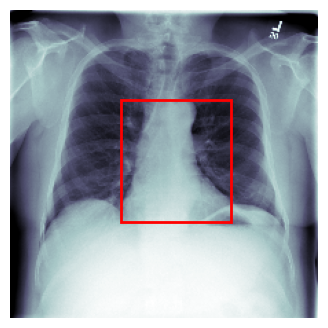

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.imshow(img, cmap='bone')
ax.add_patch(patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=2, edgecolor='r', facecolor='none'))
ax.axis('off')
plt.show()

#### Lightning Module
Untuk menginstall pytorch-lightning, gunakan `pip install pytorch-lightning`. Pytorch lightning adalah sebuah library yang mempermudah kita dalam menggunakan framework pytorch. Pytorch lightning akan mengatur training loop, validation loop, dan testing loop secara otomatis namun tetap menggunakan framework pytorch. Pytorch lightning juga memungkinkan kita untuk melakukan training pada GPU tanpa perlu menulis kode yang panjang.

In [9]:
class CardiacDetectionModule(LightningModule):
    def __init__(self, lr=1e-3, batch_size=8, num_workers=4):
        super().__init__()

        # hyperparameter
        self.lr = lr
        self.batch_size = batch_size
        self.num_workers = num_workers

        # model
        self.model = torchvision.models.resnet18(weights="DEFAULT")
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)        

        # criterion
        self.criterion = torch.nn.MSELoss()
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=10, eta_min=1e-6)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

    def train_dataloader(self):
        train_dataset = CardiacDatareader(train_df, aug=augment_image)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)
        return train_loader

    def training_step(self, batch, batch_idx):
        x, label = batch
        label = label.float()
        pred = self(x)
        loss = self.criterion(pred, label)
        return {"loss": loss}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        self.log("train_loss", avg_loss, batch_size=self.batch_size, on_step=False, on_epoch=True, prog_bar=True)
        print(f"Epch: {self.current_epoch} | Loss: {avg_loss:.2f}")

    def val_dataloader(self):
        val_dataset = CardiacDatareader(val_df)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers)
        return val_loader

    def validation_step(self, batch, batch_idx):
        x, label = batch
        x = x.unsqueeze(1)
        label = label.float()
        pred = self(x)
        loss = self.criterion(pred, label)
        
        batch_iou_list = []
        for i in range(len(pred)):
            pred_bbox = pred[i].expand(1,4)
            label_bbox = label[i].expand(1,4)
            iou = box_iou(pred_bbox, label_bbox)
            batch_iou_list.append(iou)
        batch_iou = torch.stack(batch_iou_list).mean()
        return {"val_loss": loss, "val_iou": batch_iou}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_iou = torch.stack([x['val_iou'] for x in outputs]).mean()
        self.log("val_loss", avg_loss, batch_size=self.batch_size, on_step=False, on_epoch=True, prog_bar=True)
        self.log("val_iou", avg_iou, batch_size=self.batch_size, on_step=False, on_epoch=True, prog_bar=True)
        print(f"Epoch: {self.current_epoch} | Val Loss: {avg_loss:.2f} | Val IoU: {avg_iou:.2f}")

#### Trainer

In [10]:
seed_everything(RANDOM_STATE)
model = CardiacDetectionModule(lr=1e-3, batch_size=8, num_workers=8)
wandb_logger = WandbLogger(project="tutorial-cardiac-detection", log_model=False)
wandb_logger.watch(model)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

trainer = Trainer(
    accelerator = "gpu",
    devices = 1,
    max_epochs = 30,
    precision = 16,
    enable_progress_bar = True,
    num_sanity_val_steps = 0,
    fast_dev_run = False,
    logger = wandb_logger,
    callbacks = [lr_monitor]
)

trainer.fit(model)

save_model_name = "../model/cardiac_detection.pt"
torch.save(model.state_dict(), save_model_name)

Global seed set to 45
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mctosima. Use `wandb login --relogin` to force relogin


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`
Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | ResNet  | 11.2 M
1 | criterion | MSELoss | 0     
--------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
22.345    Total estimated model params size (MB)


Epoch 29: 100%|██████████| 63/63 [00:02<00:00, 29.80it/s, loss=23.4, v_num=5u8a, val_loss=30.80, val_iou=0.844, train_loss=23.50]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: 100%|██████████| 63/63 [00:02<00:00, 26.65it/s, loss=23.4, v_num=5u8a, val_loss=30.80, val_iou=0.844, train_loss=23.50]


## Inferensi

In [11]:
test_dataset = CardiacDatareader(val_df)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=8)

In [12]:
batch = next(iter(test_loader))
x, label = batch
print(f"Image shape: {x.shape} | Label shape: {label.shape}")

Image shape: torch.Size([1, 224, 224]) | Label shape: torch.Size([1, 4])


In [13]:
class CardiacDetectionInference(LightningModule):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet18(weights="DEFAULT")
        model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        model.fc = torch.nn.Linear(in_features=512, out_features=4, bias=True)

        self.model = model

    def forward(self, x):
        return self.model(x)

In [14]:
model = CardiacDetectionInference()
model.load_state_dict(torch.load("../model/cardiac_detection.pt"))
model.eval()
x = x.unsqueeze(0)
pred = model(x)

In [15]:
pred = pred.cpu().detach()
iou_score = box_iou(pred, label)
pred = pred.squeeze()
label = label.squeeze()
iou_score = iou_score.squeeze().squeeze()
print(f"Hasil IoU: {iou_score:.2f}")

Hasil IoU: 0.96


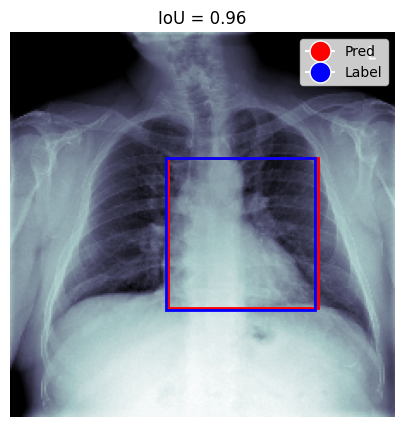

In [16]:
plt.figure(figsize=(5,5))
plt.title(f"IoU = {iou_score:.2f}")
plt.imshow(x.squeeze(), cmap="bone")
bbox_pred = patches.Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1], linewidth=2, edgecolor='r', facecolor='none')
bbox_label = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], linewidth=2, edgecolor='b', facecolor='none')
plt.gca().add_patch(bbox_pred)
plt.gca().add_patch(bbox_label)
plt.axis("off")

legend_elements = [Line2D([0], [0], marker='o', color='w', label='Pred', markerfacecolor='r', markersize=15),
                     Line2D([0], [0], marker='o', color='w', label='Label', markerfacecolor='b', markersize=15)]
plt.legend(handles=legend_elements, loc='upper right')
plt.show()